In [ ]:
# Imports 
import os
import numpy as np
import h5py
from sklearn.ensemble import RandomForestRegressor
import SnowDepth as SD

In [7]:
""" Set necessary variables """

# Select test AOI folder name
test_aoi = "ID_BS"

# Select bands to use for input features. If None, use all features. 
# Example: To choose VH_dB, VV_dB: feature_idxs = [0, 1]
feature_idxs = None  # Order: [VH_dB, VV_dB, CrossPolRatio_dB, DEM, sin(Aspect), cos(Aspect), Slope]

# Assign seed
seed = 18

In [ ]:
""" Create HDF5-files of training and test data (only once) """

data_dir = "data/tif_files"
out_dir  = "data/train_test"
train_h5 = os.path.join(out_dir, "train.h5")
test_h5  = os.path.join(out_dir, "test.h5")

if 'h5_ready' not in locals():
    if not (os.path.exists(train_h5) and os.path.exists(test_h5)):
        SD.create_h5(
            data_dir=data_dir,
            out_dir=out_dir,
            test_aoi=test_aoi
        )
    h5_ready = True 


""" Load data, split to train/validation/test """ 

# Splitting strategy
strategy = "simple_rf"

(X_train, y_train), (X_val, y_val) = SD.dataset.split_data(
    strategy=strategy,
    train_h5=train_h5,
    seed=seed,
    features=feature_idxs
) 

# Load test
with h5py.File(test_h5, "r") as f:
    X_test = f["data"][:]
    y_test = f["labels"][:]

# If feature subset requested, apply it
if feature_idxs is not None:
    X_test = X_test[:, feature_idxs]

# Filter out invalid SD samples (<=0 or NaN)
valid_mask = (y_test > 0) & ~np.isnan(y_test)
n_invalid  = y_test.size - valid_mask.sum()
X_test = X_test[valid_mask]
y_test = y_test[valid_mask]

RF split: train samples = 11200, val samples = 4800, features = ['VH_dB', 'VV_dB', 'CrossPolRatio_dB', 'DEM', 'sin(Aspect)', 'cos(Aspect)', 'Slope']


In [ ]:
""" Train models """

# Instantiate and fit RF model
rf = RandomForestRegressor(
    n_estimators=200,
    max_features='sqrt',
    random_state=seed,
    n_jobs=-1
)
rf.fit(X_train, y_train)


In [ ]:
""" Evaluate models """

# Compute metrics on train & val
train_metrics = SD.evaluate(rf, X_train, y_train)
val_metrics   = SD.evaluate(rf, X_val, y_val)

print("=== Training metrics ===")
print(train_metrics)
print("\n=== Validation metrics ===")
print(val_metrics)

# Scatter plot of observed vs. predicted on the validation set
y_val_pred = rf.predict(X_val)
SD.plot_scatter(y_val, y_val_pred)


=== Test metrics ===
{'MAE': 0.38171217519969697, 'RMSE': 0.4675435336040757, 'R2': -0.01017946824748428}


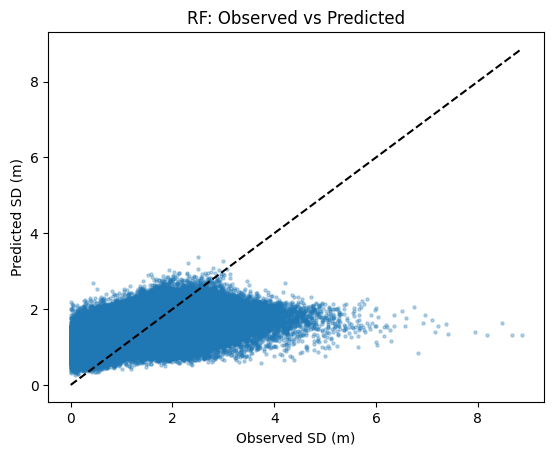

In [10]:
# Compute & print test metrics
test_metrics = SD.evaluate_split(rf, X_test, y_test)
print("\n=== Test metrics ===")
print(test_metrics)

# Scatter plot: observed vs. predicted
y_pred_test = rf.predict(X_test)
SD.plot_scatter(y_test, y_pred_test)